In [1]:
# Introduction

In [2]:
## We need to first import the necessary packages and files

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from pathlib import Path
from numpy import exp
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
heart_disease_training= pd.read_csv("C:/Users/Calvi/Documents/Data Science Toolbox/Assessment 1/data/TrainingDataImputation.csv")
heart_disease_test = pd.read_csv("https://raw.githubusercontent.com/erinp0/DST-Assessment-1/main/Erin%20Pollard/test_imputed.csv")

In [5]:
## We then separate the features and target variables

In [6]:
y_train = np.array(heart_disease_training.iloc[:, 0]).astype(int)[np.newaxis,:].T
y_test = np.array(heart_disease_test.iloc[:, 0]).astype(int)[np.newaxis,:].T
del heart_disease_training['HeartDiseaseorAttack']
del heart_disease_test['HeartDiseaseorAttack']

In [7]:
x_train = heart_disease_training.to_numpy()
x_test = heart_disease_test.to_numpy()

In [8]:
def center_function(data):
    mean = data.mean(axis=1)
    std = data.std(axis=1)
    for i in range(data.shape[1]):
        data[i] -= mean[i]
        data[i] /= std[i]
    return data,mean,std

In [9]:
cf = center_function(x_train)
x_train_centered = cf[0]

In [10]:
print("Standardised Training Data:")
print(pd.DataFrame(x_train_centered).head())

Standardised Training Data:
         0         1         2         3         4         5         6   \
0  1.392049  0.099506  1.392049 -0.495064  0.099506  0.099506 -0.331341   
1  0.827005  0.827005  0.827005 -1.354394  0.827005 -0.731137 -1.250518   
2  1.013108  1.013108  1.013108 -1.047109  1.013108 -0.398000 -0.868369   
3 -0.099784  1.527512 -1.727079 -0.718156  1.527512 -0.099784 -0.642215   
4  0.693649  0.693649  0.693649 -1.398234  0.693649  0.693649 -1.243280   

         7         8         9   ...        11        12        13        14  \
0 -1.193037 -1.193037 -1.193037  ...  1.392049  0.099506  0.530354 -1.109647   
1 -0.731137  0.827005  0.827005  ...  0.827005 -0.731137  0.827005  0.827005   
2 -0.398000  1.013108  1.013108  ...  1.013108 -1.809108  0.072370 -1.718068   
3 -0.099784 -0.099784 -0.099784  ...  1.527512 -0.099784  0.442648 -1.622092   
4  0.693649  0.693649  0.693649  ...  0.693649  0.693649  0.693649 -2.211744   

         15        16        17        1

In [11]:
# PCA

In [12]:
percentage = 99 # This is the amount of explained variance we desire

In [13]:
def cov_eigen(data):
    hd_scaled = StandardScaler().fit_transform(data)
    features = hd_scaled.T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)
    idx = values.argsort()[::-1]
    vectors = vectors.T[:,idx]
    return values,vectors

In [14]:
def pcafeatures(data,percentage):
    hd_scaled = StandardScaler().fit_transform(data)
    features = hd_scaled.T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)
    explained_variances = []
    a = 0
    num = 0
    for i in range(len(values)):
        explained_variances.append(values[i] / np.sum(values))
    for i in range(len(explained_variances)):
        while a < percentage:
            a += explained_variances[i]*100
            num += 1
    pc_feat = ['PC{}'.format(i+1) for i in range(num)]
    return pc_feat,num,explained_variances

In [15]:
num_of_comps = pcafeatures(x_train_centered,percentage)[1]
cov_evecs = cov_eigen(x_train_centered)[1][:,:num_of_comps]

In [16]:
print("Covariance Eigenvectors:")
print(pd.DataFrame(cov_evecs).head())

Covariance Eigenvectors:
          0         1         2         3         4         5         6  \
0  0.230155  0.299364  0.255722  0.233122  0.274376  0.094727  0.050708   
1  0.240133  0.117451  0.015781  0.016640  0.025990  0.155201  0.052722   
2  0.195575  0.399363  0.404610 -0.080045 -0.206620  0.023697  0.021132   
3 -0.080941  0.003162  0.024523 -0.472549 -0.199250  0.026598 -0.029317   
4 -0.198336  0.096286  0.185616  0.025567 -0.261685 -0.095806 -0.019158   

          7  
0  0.281208  
1 -0.334645  
2 -0.163307  
3  0.140227  
4 -0.073501  


In [17]:
x_train_pca = np.dot(x_train_centered,cov_evecs)

In [18]:
print(pd.DataFrame(x_train_pca[:5,:], columns = pcafeatures(x_train_centered,percentage)[0]))

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.662519  1.311592  1.373117  1.443065 -0.402265 -1.146267 -0.349838   
1 -0.480979  0.997683  2.252750  1.130848  0.222968 -0.444043 -0.703155   
2 -0.587278  0.809456  0.996251  0.932349  0.048568 -0.012965 -0.613390   
3 -1.011594 -0.429784 -0.525450  0.881224 -0.342470 -0.070817 -0.675218   
4 -0.679013  0.067289  0.840971  1.590689 -0.505015  1.237988 -1.288372   

        PC8  
0  1.236284  
1  0.086942  
2 -0.196388  
3  0.738086  
4  0.176296  


In [19]:
# Logistic Regression

In [20]:
#%% Parameter initialize and sigmoid function

def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

def sigmoid(z):
    y_head = 1 / (1+exp(-z))
    return y_head

In [21]:
### The sigmoid function is used for deciding the probability. It's clear from the graph below that the the higher the input it, the closer it tends to 1 and the lower it is, the closer it tends to 0. As we are working with binary classification, the only outcomes we desire are 1 or 0.

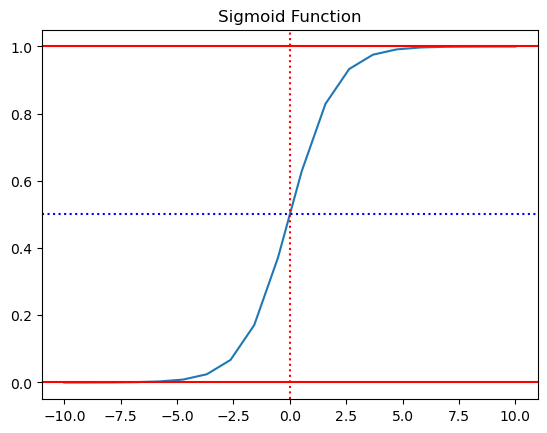

In [22]:
x_axis = np.linspace(-10,10,20)
plt.plot(x_axis,sigmoid(x_axis))
plt.axhline(y=1,color = 'r',linestyle = '-')
plt.axhline(y=0,color = 'r',linestyle = '-')
plt.axhline(y=0.5,color = 'b', linestyle = ':')
plt.axvline(x=0,color = 'r', linestyle = ':')
plt.title("Sigmoid Function")

plt.show()

In [23]:
#%% Loss function

def logloss(y_hat,y):
    a = np.log(y_hat)
    b = np.log(1-y_hat)
    loss = (-1/x_train.shape[0]) * np.sum(y*a + (1-y)*b)
    return loss

In [24]:
#%% Forward and Backward Propagation

def forward_backward_propagation(w,b,x_train,y_hat):
    
    z = np.dot(x_train,w) + b
    y_hat = sigmoid(z)
    cost = logloss(y_hat,y_train)
    
    #backward propogation
    derivative_weight = np.dot((y_hat-y_train).T,x_train)/x_train.shape[0]
    derivative_bias = np.sum(y_hat-y_train)/x_train.shape[0]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

In [25]:
#%% Updating (Learning) Parameters
    
def update(w, b, x_train, y_train, learning_rate,number_of_iteration):
    cost_list = []
    cost_list2 = []
    index = []
    # updating(learning) parameters is number_of_iteration times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        # lets update
        w = w - learning_rate * (gradients["derivative_weight"].T)
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 50 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost)) #if section defined to print our cost values in every 10 iteration. We do not need to do that. It's optional.
     # we update(learn) parameters weights and bias
    parameters = {"weight": w,"bias": b}
    plt.plot(range(len(cost_list)),cost_list)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list 

In [26]:
#%% Prediction

def predict(w,b,x_test):
    # x_test is a input for forward propagation
    z = sigmoid(np.dot(x_test,w)+b)
    Y_prediction = np.zeros((x_test.shape[0],1))
    # if z is bigger than 0.5, our prediction is one means has diabete (y_head=1),
    # if z is smaller than 0.5, our prediction is zero means does not have diabete (y_head=0),
    for i in range(len(z)):
        if z[i]< 0.5:
            Y_prediction[i] = 0
        else:
            Y_prediction[i] = 1

    return Y_prediction

#predict(parameters["weight"],parameters["bias"],x_test)

In [27]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialise
    dimension =  x_train.shape[1]
    w,b = initialize_weights_and_bias(dimension)
    
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)

    # Print train/test Errors
    
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

In [28]:
def probabilities(x_train, x_test, y_train, learning_rate,number_of_iteration):
    # initialise
    dimension =  x_train.shape[1]
    w,b = initialize_weights_and_bias(dimension)
    # updating(learning) parameters is number_of_iteration times
    for i in range(number_of_iteration):
        # make forward and backward propagation and find cost and gradients
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        # lets update
        w = w - learning_rate * (gradients["derivative_weight"].T)
        b = b - learning_rate * gradients["derivative_bias"]
        z = sigmoid(np.dot(x_test,w)+b)
    return z

In [29]:
## We need to prepare our test dataset before predicting the outcome. We need to project the test data into the same space as the training. So we follow the standardising method but use the mean and standard deviation from the training data

In [30]:
for i in range(x_test.shape[1]):
    x_test[:,i] -= cf[1][i]     
    x_test[:,i] /= cf[2][i]

In [31]:
x_test_pca = np.dot(x_test,cov_evecs)

In [32]:
# With and without PCA Comparison

In [33]:
## Without PCA:

Cost after iteration 0: 0.747076
Cost after iteration 50: 0.227278
Cost after iteration 100: 0.217142
Cost after iteration 150: 0.212736
Cost after iteration 200: 0.210201


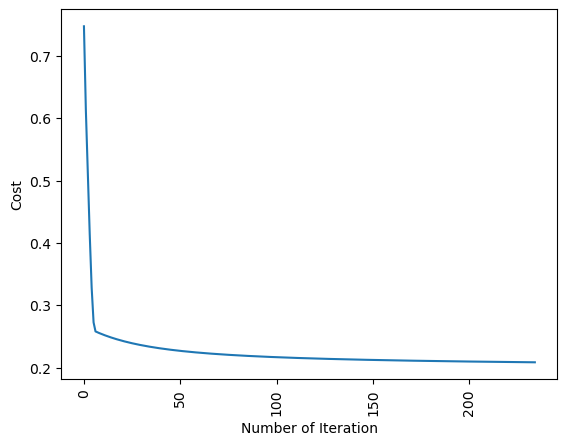

test accuracy: 69.11591355599214 %


In [34]:
start = time.time()
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 2, num_iterations = 235)
end = time.time()

In [35]:
print("Without PCA, execution time of Logistic Regression is: " + str(end-start))

Without PCA, execution time of Logistic Regression is: 20.094748497009277


In [36]:
## With PCA

Cost after iteration 0: 0.711229
Cost after iteration 50: 0.243475
Cost after iteration 100: 0.232930
Cost after iteration 150: 0.227868
Cost after iteration 200: 0.225143


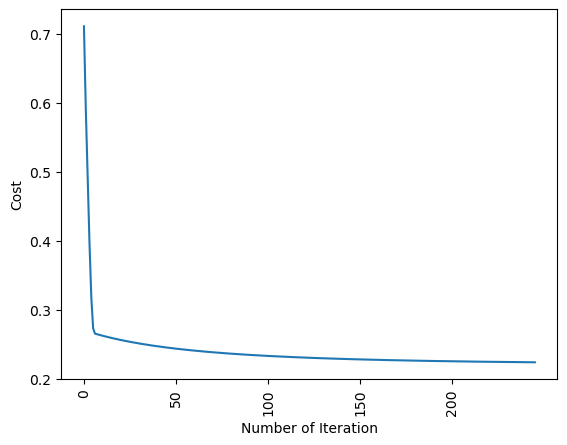

test accuracy: 70.56974459724951 %


In [37]:
start=time.time()
logistic_regression(x_train_pca, y_train, x_test_pca, y_test,learning_rate =4 , num_iterations = 246)
end=time.time()

In [38]:
print("With PCA, execution time of Logistic Regression is: " + str(end-start))

With PCA, execution time of Logistic Regression is: 17.090739965438843


In [39]:
## We can look at the probabilities before they are assigned 1 or 0

In [40]:
y_hat = probabilities(x_train_pca, x_test_pca, y_train, learning_rate = 4,number_of_iteration = 246)

In [41]:
y_hat = pd.DataFrame(y_hat, columns = ['Probabilities'])

In [42]:
print(y_hat)

       Probabilities
0           0.561522
1           0.441240
2           0.996824
3           0.011181
4           0.520093
...              ...
15265       0.039427
15266       0.013973
15267       0.672678
15268       0.005239
15269       0.183782

[15270 rows x 1 columns]
